# Introduction

This notebook provides a detailed walkthrough of the data preprocessing, feature engineering, and evaluation steps behind a machine learning pipeline for detecting money laundering in financial transaction data. While the actual model training and prediction logic is implemented in a separate script/module, this notebook serves as the documentation and analytical backbone of the project—highlighting what happens "behind the scenes."

### Objectives:
- Explore and clean the dataset to ensure quality input for modeling.
- Engineer meaningful features that capture transaction behavior, time patterns, and network structure.
- Visualize class imbalance and correlation among features.
- Apply SMOTE to address severe class imbalance.
- Perform cross-validation and assess performance using metrics like ROC AUC, F1 score, and confusion matrix.
- Interpret model decisions through SHAP values and gain-based feature importances.

This notebook is part of a larger AML (Anti-Money Laundering) detection system, and aims to explain the logic, transformations, and decisions that support the model's predictive power.

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_recall_curve, roc_auc_score,
    average_precision_score, classification_report, f1_score
)
from imblearn.over_sampling import SMOTE

df = pd.read_csv('../data/processed_transactions.csv')
print("Dataset loaded:", df.shape)
df.head()

,amount_received,amount_paid,is_laundering,amount_diff,txn_count,total_sent,avg_txn_amount,unique_receivers,hour_of_day,day_of_week,...,receiving_currency_Saudi Riyal,receiving_currency_Shekel,receiving_currency_Swiss Franc,receiving_currency_UK Pound,receiving_currency_US Dollar,receiving_currency_Yen,receiving_currency_Yuan,out_degree,in_degree,pagerank
0,8.766890e-07,8.766890e-07,0,0.998657,40,3.290030e-06,8.225076e-08,7,0,3,...,False,False,False,False,True,False,False,7,33,0.000005
1,5.100232e-10,5.100232e-10,0,0.998657,1,5.100232e-10,5.100232e-10,1,0,3,...,False,False,False,False,True,False,False,1,1,0.000001
2,1.625774e-07,1.625774e-07,0,0.998657,40,3.290030e-06,8.225076e-08,7,0,3,...,False,False,False,False,True,False,False,7,1,0.000005
3,3.380108e-12,3.380108e-12,0,0.998657,1,3.380108e-12,3.380108e-12,1,0,3,...,False,False,False,False,True,False,False,1,1,0.000001
4,8.070447e-10,8.070447e-10,0,0.998657,42,2.023834e-09,4.818653e-11,3,0,3,...,False,False,False,False,True,False,False,3,23,0.000004


# Money Laundering Detection: Model Training and Evaluation

This section builds and evaluates an XGBoost model for detecting money laundering in financial transactions, using engineered features, SMOTE for class balancing, and cross-validation.

## Steps Overview

### 1. Data Preparation
- Loaded the processed dataset and validated required columns.
- Engineered additional features:
  - `amount_diff`, `ratio_received_paid`, `avg_txn_amount`, `z_score_paid`.

### 2. Modeling Approach
- Used **Stratified 5-Fold Cross-Validation** to preserve class distribution.
- Applied **SMOTE** to address class imbalance in training splits.
- Trained an **XGBoost classifier** with tuned hyperparameters.

### 3. Evaluation
- ROC AUC score calculated for each fold.
- Best-performing model selected and retrained.
- Applied a manual threshold (0.96) for prediction.
- Final metrics reported:
  - **ROC AUC**, **Accuracy**, **F1 Score**

This pipeline ensures robust handling of imbalanced data and emphasizes confident predictions for high-stakes AML detection.


In [ ]:
# Required columns check
REQUIRED_COLUMNS = [
    'amount_paid', 'amount_received', 'txn_count', 'total_sent',
    'hour_of_day', 'day_of_week', 'is_laundering'
]

missing = [col for col in REQUIRED_COLUMNS if col not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Feature Engineering
df['amount_diff'] = abs(df['amount_paid'] - df['amount_received'])
df['ratio_received_paid'] = df['amount_received'] / (df['amount_paid'] + 1e-5)
df['avg_txn_amount'] = df['total_sent'] / (df['txn_count'] + 1e-5)
df['z_score_paid'] = (df['amount_paid'] - df['amount_paid'].mean()) / df['amount_paid'].std()

# Preparing features and target
X = df.drop(columns=['is_laundering'])
y = df['is_laundering']

# SMOTE + Cross-validation performed
smote = SMOTE(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = []
scores = []
print("Starting 5-fold training...")

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print(f"▶️ Fold {fold+1}")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    model = xgb.XGBClassifier(
        n_estimators=300,
        max_depth=9,
        learning_rate=0.03,
        subsample=0.85,
        colsample_bytree=0.85,
        scale_pos_weight=1,
        eval_metric='logloss',
        random_state=42
    )

    model.fit(X_train_res, y_train_res)

    y_proba = model.predict_proba(X_val)[:, 1]
    roc_score = roc_auc_score(y_val, y_proba)
    scores.append(roc_score)
    print(f"Fold {fold+1} ROC AUC: {roc_score:.4f}")

    models.append(model)

# Final evaluation on best fold
best_model_idx = np.argmax(scores)
best_model = models[best_model_idx]
manual_threshold = 0.96

# Getting validation data for that selected fold
X_train, X_val = X.iloc[list(cv.split(X, y))[best_model_idx][0]], X.iloc[list(cv.split(X, y))[best_model_idx][1]]
y_train, y_val = y.iloc[list(cv.split(X, y))[best_model_idx][0]], y.iloc[list(cv.split(X, y))[best_model_idx][1]]

X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
best_model.fit(X_train_res, y_train_res)

y_val_proba = best_model.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_proba >= manual_threshold).astype(int)

roc = roc_auc_score(y_val, y_val_proba)
acc = accuracy_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print(f"\nBest Fold: {best_model_idx + 1}")
print(f"ROC AUC: {roc:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Using Manual Threshold: {manual_threshold:.3f}")

Dataset loaded: (6924049, 47)
Starting 5-fold training...
▶️ Fold 1
Fold 1 ROC AUC: 0.9579
▶️ Fold 2
Fold 2 ROC AUC: 0.9521

Best Fold: 1
ROC AUC: 0.9579
Accuracy: 0.9983
F1 Score: 0.1157
Using Manual Threshold: 0.960


# Threshold Optimization: Precision, Recall, and F1

To evaluate the impact of classification thresholds, precision, recall, and F1 score were computed across a range of thresholds using the model’s predicted probabilities.
- Visualized how each metric changes with threshold.
- A vertical line highlights the current threshold (0.97) used for final predictions.

This plot supports selecting an optimal threshold based on business or risk requirements (e.g., favoring high precision or recall).

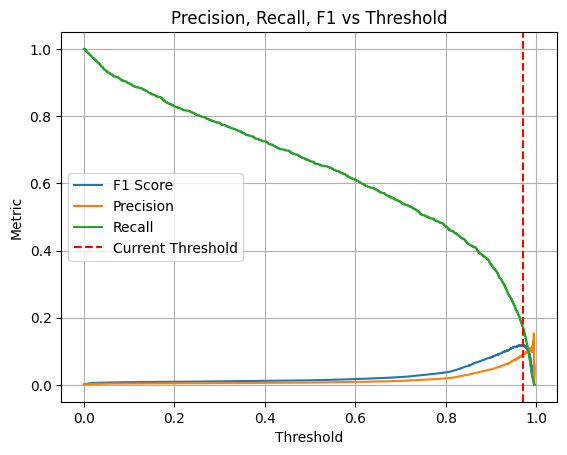

In [12]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_scores = best_model.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, y_scores)
f1 = 2 * (precision * recall) / (precision + recall + 1e-10)

plt.plot(thresholds, f1[:-1], label='F1 Score')
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.axvline(x=0.97, color='red', linestyle='--', label='Current Threshold')
plt.xlabel("Threshold")
plt.ylabel("Metric")
plt.legend()
plt.title("Precision, Recall, F1 vs Threshold")
plt.grid()
plt.show()


# Precision-Recall Curve

A Precision-Recall (PR) curve was plotted to evaluate model performance on imbalanced data. This curve is especially useful when the positive class (money laundering) is rare.
- The curve shows the trade-off between precision and recall at various thresholds.
- Useful for assessing how well the model identifies positive cases without introducing excessive false positives.

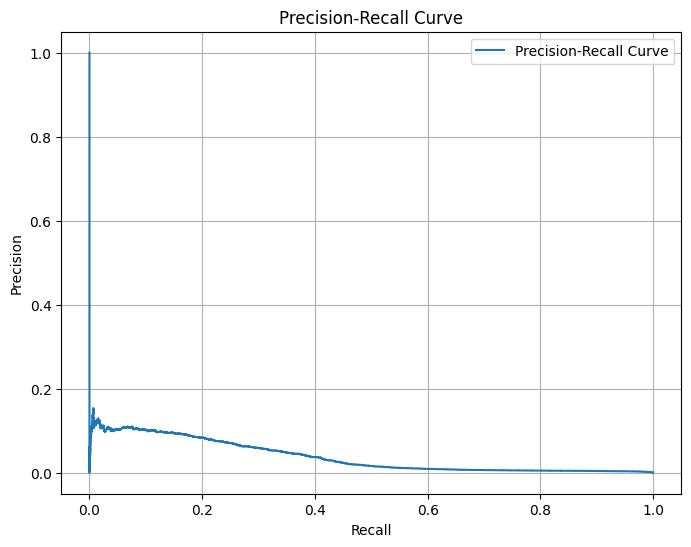

In [14]:
# PR Plot
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

# ROC Curve

The Receiver Operating Characteristic (ROC) curve was used to evaluate the classifier's ability to distinguish between laundering and non-laundering transactions.

- Plotted True Positive Rate (TPR) vs. False Positive Rate (FPR).
- AUC (Area Under the Curve) provides a single metric of separability.
- AUC close to 1.0 indicates strong classification performance.


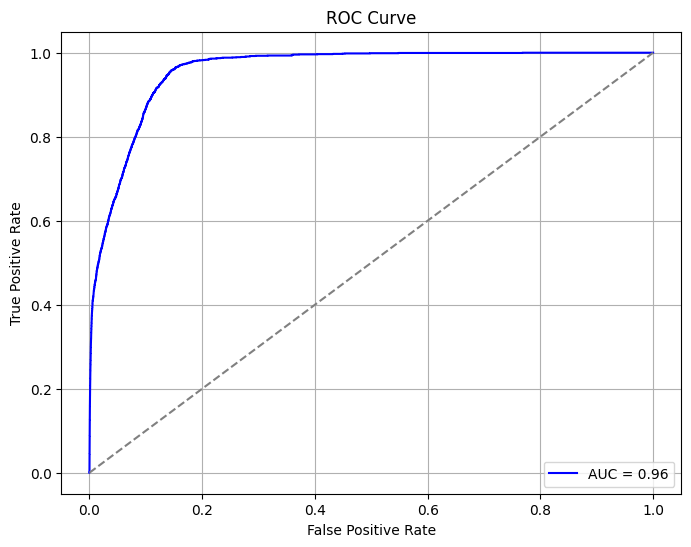

In [21]:
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt

X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

y_proba = best_model.predict_proba(X_val)[:, 1]

fpr, tpr, _ = roc_curve(y_val, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# Confusion Matrix

The confusion matrix evaluates the model's performance using a threshold of 0.96.

- **True Negatives (Non-Laundering correctly classified):** 3,455,920  
- **False Positives:** 4,322  
- **False Negatives (Laundering missed):** 1,408  
- **True Positives (Laundering detected):** 375

While the model achieves strong performance on the majority class, the confusion matrix highlights the trade-off between false positives and missed laundering cases under a strict threshold.

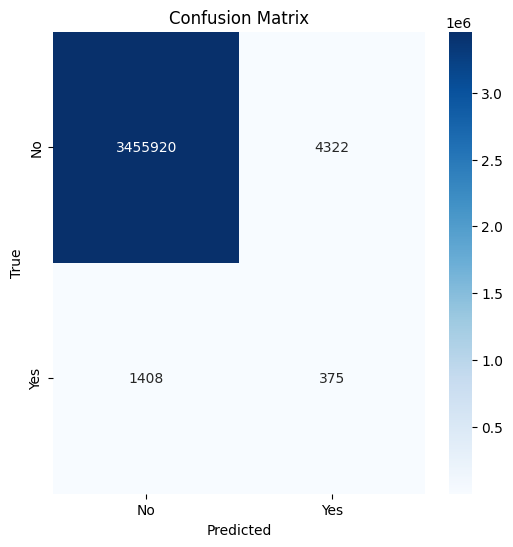

In [ ]:
from sklearn.metrics import confusion_matrix

X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_val_proba = best_model.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_proba >= manual_threshold).astype(int)

cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature Importance by Gain (XGBoost)

The top 10 features were ranked based on **gain**, which measures the average improvement in model performance from splits on each feature.

- `payment_format_Reinvestment`, `Wire`, and `Credit Card` were the most influential features.
- Network-based (`out_degree`) and engineered features (`ratio_received_paid`, `amount_diff`) also contributed significantly.

This analysis helps prioritize which features the model relies on most during decision-making.


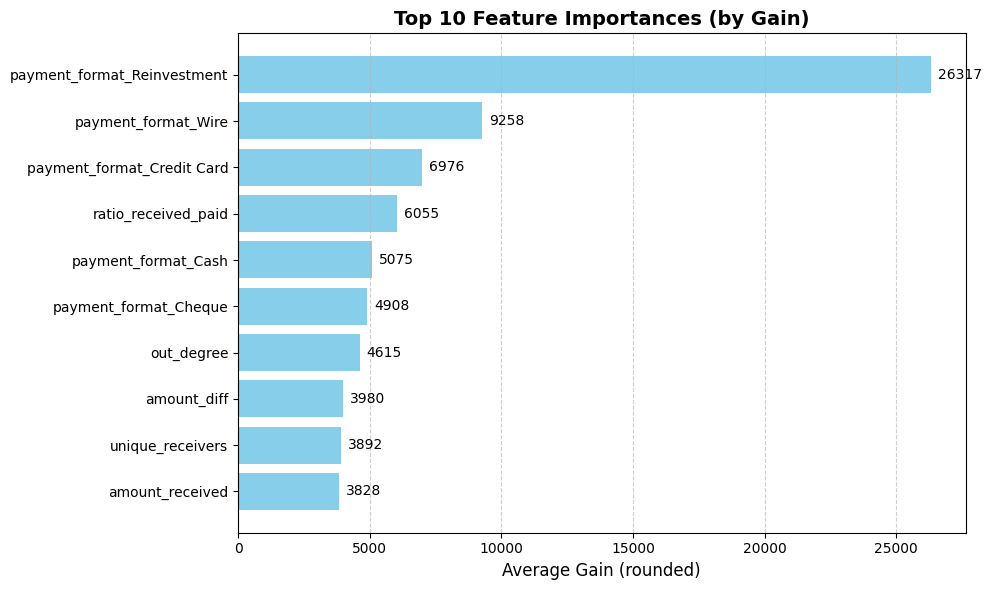

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Feature importance based on model inputs
importance_dict = model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame(
    list(importance_dict.items()), columns=["Feature", "Gain"]
).sort_values(by="Gain", ascending=False).head(10)

plt.figure(figsize=(10, 6))
bars = plt.barh(
    importance_df["Feature"], 
    importance_df["Gain"], 
    color='skyblue'
)

plt.gca().invert_yaxis()  
plt.title("Top 10 Feature Importances (by Gain)", fontsize=14, weight='bold')
plt.xlabel("Average Gain (rounded)", fontsize=12)

for bar in bars:
    width = bar.get_width()
    plt.text(
        width + max(importance_df["Gain"]) * 0.01,  
        bar.get_y() + bar.get_height() / 2,
        f"{int(round(width))}",
        va='center', fontsize=10
    )
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# SHAP Feature Importance (Model Explainability)

SHAP (SHapley Additive exPlanations) was used to interpret the model's output by quantifying each feature’s contribution to individual predictions.

- The summary plot shows the top features ranked by average impact.
- Color represents feature value (red = high, blue = low).
- `txn_count`, `unique_receivers`, and `amount_received` are among the most influential features in predicting laundering behavior.

This interpretability step adds transparency and supports trust in the model’s decisions.

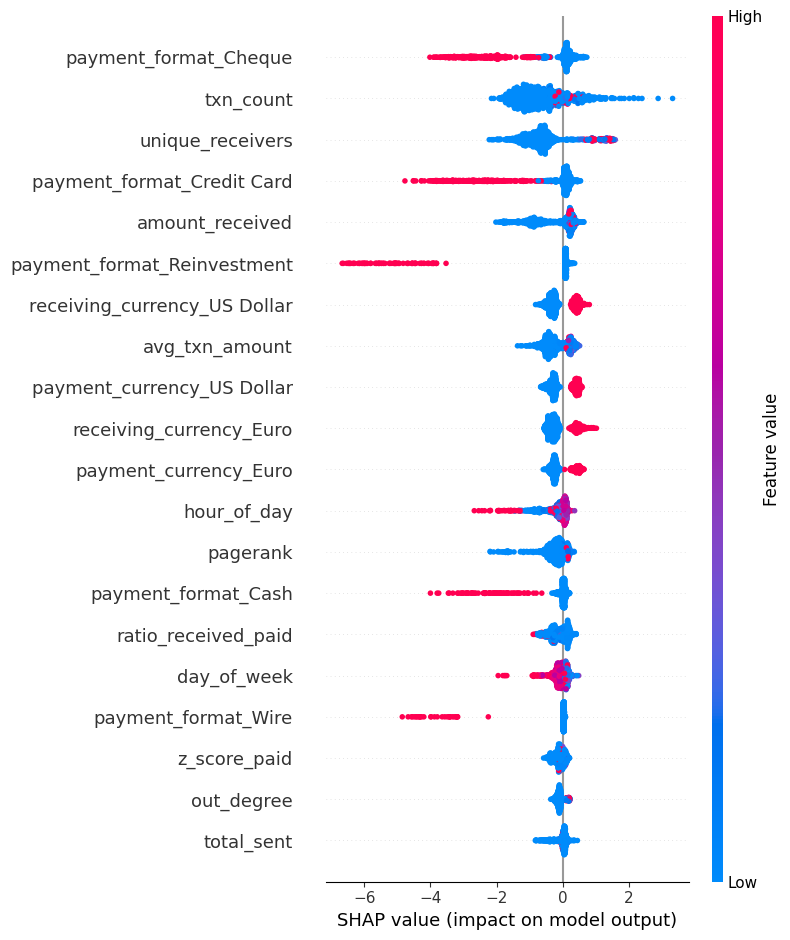

In [26]:
import shap
import matplotlib.pyplot as plt

X_sample = X_val.sample(n=1000, random_state=42).reset_index(drop=True)

explainer = shap.Explainer(best_model)  

shap_values = explainer(X_sample)

# Plot summary
shap.summary_plot(shap_values, X_sample)
